In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path

%matplotlib inline


In [35]:
# file[14:19] extracts the year from the filename; to be used in the tax_files dict to deal with differences
# in formatting between files

path = os.getcwd() + '\data_sources\demand\CA_tax_returns\\'
tax_files = {}
for file in os.listdir(path):
    tax_files[int(file[14:19])] = path+file

In [36]:
# dataset for each year is formatted slightly differently
rows_to_skip = {2014:5, 2013:5, 2012:5, 2011:5, 2010:5, 2009:5, 2008:9, 2007:8}

# column labels change slightly from year to year--we are only interested in the first few columns
# so we will rename those of interest. '0' label is filler to simplify the for loop for renaming later
column_labels = {2014:['zipcode',
                  'gross_income_bracket',
                  'tax_returns_2014',
                  'single_returns_2014',
                  'joint_returns_2014'],
                 2013:['zipcode',
                  'gross_income_bracket',
                  'tax_returns_2013',
                  'single_returns_2013',
                  'joint_returns_2013'],
                 2012:['zipcode',
                  'gross_income_bracket',
                  'tax_returns_2012',
                  'single_returns_2012',
                  'joint_returns_2012'],
                 2011:['zipcode',
                  'gross_income_bracket',
                  'tax_returns_2011',
                  #'single_returns',
                  'joint_returns_2011',
                      '0'],
                 2010:['zipcode',
                  'gross_income_bracket',
                  'tax_returns_2010',
                  #'single_returns',
                  'joint_returns_2010',
                      '0'],
                 2009:['zipcode',
                  'gross_income_bracket',
                  'tax_returns_2009',
                  #'single_returns',
                  'joint_returns_2009',
                      '0'],
                 2008:['gross_income_bracket',
                  'zipcode',
                  'tax_returns_2008',
                  #'single_returns',
                  'joint_returns_2008',
                      '0'],
                 2007:['gross_income_bracket',
                  'zipcode',
                  'tax_returns_2007',
                  #'single_returns',
                  'joint_returns_2007',
                      '0']
                }

In [37]:
# read in all excel files to dict of DataFrames
ca_tax = {}
for year in range(2007,2015):
    ca_tax[year] = pd.read_excel(tax_files[year],skiprows=rows_to_skip[year])

In [38]:
# create dict of dicts to pair columns of interest with their proper descriptive column labels for each year
column_dict = {}

for year in range(2007,2015):
    temp_dict = {}
    i = 0
    for old_label in list(ca_tax[year])[0:5]:
        temp_dict[old_label] = column_labels[year][i]
        i+=1
    column_dict[year] = temp_dict

In [39]:
# to differentiate same columns from different years, for when we join the tables together
rsuffixes = ['_2007','_2008','_2009','_2010','_2011','_2012','_2013','_2014']

In [40]:
# use the dict above to rename desired columns
i = 0
for year in ca_tax:
    ca_tax[year] = ca_tax[year].rename(columns=column_dict[year])
    ca_tax[year] = ca_tax[year][['zipcode','gross_income_bracket','tax_returns'+rsuffixes[i],'joint_returns'+rsuffixes[i]]]
    ca_tax[year] = ca_tax[year].dropna()
    ca_tax[year] = ca_tax[year].replace(to_replace='*',value=0)
    ca_tax[year] = ca_tax[year].replace(to_replace='.',value=0)
    ca_tax[year]['zipcode'] = ca_tax[year]['zipcode'].astype(str)
    ca_tax[year]['tax_returns'+rsuffixes[i]] = ca_tax[year]['tax_returns'+rsuffixes[i]].astype(int)
    ca_tax[year]['joint_returns'+rsuffixes[i]] = ca_tax[year]['joint_returns'+rsuffixes[i]].astype(int)
    i+=1

In [41]:
ca_tax[2007].dtypes

zipcode                 object
gross_income_bracket    object
tax_returns_2007         int32
joint_returns_2007       int32
dtype: object

In [42]:
ca_tax[2008]['gross_income_bracket'][0:7]

1              Under $10,000
2      $10,000 under $25,000
3      $25,000 under $50,000
4      $50,000 under $75,000
5     $75,000 under $100,000
6    $100,000 under $200,000
7           $200,000 or more
Name: gross_income_bracket, dtype: object

In [43]:
labels = ['<$10,000','$10,000-$25,000','$25,000-$50,000','$50,000-$75,000','$75,000-$100,000','$100,000-$200,000','>$200,000']

In [44]:
new_bracket_labels = {}
i = 0
for bracket in ca_tax[2008]['gross_income_bracket'][0:7]:
    new_bracket_labels[bracket] = labels[i]
    i+=1
new_bracket_labels

{'$10,000 under $25,000': '$10,000-$25,000',
 '$100,000 under $200,000': '$100,000-$200,000',
 '$200,000 or more': '>$200,000',
 '$25,000 under $50,000': '$25,000-$50,000',
 '$50,000 under $75,000': '$50,000-$75,000',
 '$75,000 under $100,000': '$75,000-$100,000',
 'Under $10,000': '<$10,000'}

In [45]:
ca_tax[2014]['gross_income_bracket'][0:7]

0                      Total
1           $1 under $25,000
2      $25,000 under $50,000
3      $50,000 under $75,000
4     $75,000 under $100,000
5    $100,000 under $200,000
6           $200,000 or more
Name: gross_income_bracket, dtype: object

In [46]:
# formatting on files changes--manually including new label from recent years
new_bracket_labels['$1 under $25,000'] = '<$25,000'

In [47]:
# fix bracket labels for readability 
for year in ca_tax:
    for old_label in new_bracket_labels:
        ca_tax[year] = ca_tax[year].replace(to_replace=old_label,value=new_bracket_labels[old_label])

In [48]:
# strange formatting error with 2008 when file was read in
# pandas added listed zipcodes as strings with '.0' appended. needed to convert to float, then to int to truncate .0,
# and finally back to str
ca_tax[2008]['zipcode'] = ca_tax[2008]['zipcode'].astype(float)
ca_tax[2008]['zipcode'] = ca_tax[2008]['zipcode'].astype(int)
ca_tax[2008]['zipcode'] = ca_tax[2008]['zipcode'].astype(str)

In [49]:
# initialize master DataFrame with left-most DataFrame
# note: '0' zipcode is the total of all zipcodes listed
ca_tax_master = ca_tax[2007]
ca_tax_master = ca_tax_master.set_index(['zipcode','gross_income_bracket'])

In [50]:
for year in range(2008,2015):
    ca_tax_master = ca_tax_master.join(ca_tax[year].set_index(['zipcode','gross_income_bracket']),how='outer')

In [51]:
# to fix the brackets: 2007 and 2008 were formatted with brackets 10,000-25,000 and <10,000
# all years after that use a single bracket: <25,000. sum the 10,000-25,000 and <10,000 brackets to 
# format 2007 and 2008 with brackets that are consistent with the later years
# use the indices together with .loc and a for loop to assign (10,000-25,000 + < 10,000) to <25,000 for 2007 and 2008
# then delete 10,000-25,000 and <10,000

zipcodes_list = ca_tax_master.index.levels[0]

In [52]:
# there are zipcodes which do not have the <$25,000 bracket: these are the zipcodes which are not listed in the
# later (2009-2014) years. i.e. when we performed the join, the row was not added because they did not exist
# in the later years, which used the <$25,000 bracket. we will drop these rows (they have a bunch of missing information)
# so we will not bother to fix their brackets
print(len(ca_tax_master.loc['96160']))

7


In [53]:
# the for loop runs into an error without the if statement
# we could adjust it to retain and fix information on the <= 7 years, but again, there is no sense 
# in doing this because we are dropping these data-lacking rows
for zc in zipcodes_list:
    if len(ca_tax_master.loc[zc]) > 7:
        under25k2007 = ca_tax_master.loc[zc].loc['$10,000-$25,000']['tax_returns_2007'] + ca_tax_master.loc[zc].loc['<$10,000']['tax_returns_2007']
        ca_tax_master.loc[zc].loc['<$25,000']['tax_returns_2007'] = under25k2007
        under25k2008 = ca_tax_master.loc[zc].loc['$10,000-$25,000']['tax_returns_2008'] + ca_tax_master.loc[zc].loc['<$10,000']['tax_returns_2008']
        ca_tax_master.loc[zc].loc['<$25,000']['tax_returns_2008'] = under25k2008
        under25k2007joint = ca_tax_master.loc[zc].loc['$10,000-$25,000']['joint_returns_2007'] + ca_tax_master.loc[zc].loc['<$10,000']['joint_returns_2007']
        ca_tax_master.loc[zc].loc['<$25,000']['joint_returns_2007'] = under25k2007joint
        under25k2008joint = ca_tax_master.loc[zc].loc['$10,000-$25,000']['joint_returns_2008'] + ca_tax_master.loc[zc].loc['<$10,000']['joint_returns_2008']
        ca_tax_master.loc[zc].loc['<$25,000']['joint_returns_2008'] = under25k2008joint

In [54]:
# at this point, any rows with complete information have no NaN values for the rows we are interested in
# we will use dropna() to remove the 10,000 - 25,000 and <10,000 rows, as well as remove zipcodes
# with missing information for many years
ca_tax_master = ca_tax_master.dropna()

In [55]:
# split the datasets

ca_joint_returns = ca_tax_master[['joint_returns_2007',
                                  'joint_returns_2008',
                                  'joint_returns_2009',
                                  'joint_returns_2010',
                                  'joint_returns_2011',
                                  'joint_returns_2012',
                                  'joint_returns_2013',
                                  'joint_returns_2014']]
ca_tax_returns = ca_tax_master[['tax_returns_2007',
                                'tax_returns_2008',
                                'tax_returns_2009',
                                'tax_returns_2010',
                                'tax_returns_2011',
                                'tax_returns_2012',
                                'tax_returns_2013',
                                'tax_returns_2014']]

In [56]:
# when we plot the brackets, they will be ordered correctly this way. also fixes the formatting issue with $ 
# ideally should have done this at the beginning of wrangling when we first fixed labels (redundant work)
# much of the above wrangling was done based on the first labels; will not change the original work for minor 
# efficiency upgrade
rename_brackets = {'<$25,000':'0: < 25,000',
                 '$25,000-$50,000':'1: 25,000-50,000',
                 '$50,000-$75,000':'2: 50,000-75,000',
                 '$75,000-$100,000':'3: 75,000-100,000',
                 '$100,000-$200,000':'4: 100,000-200,000',
                 '>$200,000':'5: > 200,000'}

In [57]:
# fixing labels
ca_tax_returns = ca_tax_returns.reset_index()
for old_bracket in rename_brackets:
    ca_tax_returns = ca_tax_returns.replace(to_replace=old_bracket,value=rename_brackets[old_bracket])
ca_tax_returns = ca_tax_returns.set_index(['zipcode','gross_income_bracket'])
ca_tax_returns = ca_tax_returns.sort_index() 

In [58]:
# fixing labels
ca_joint_returns = ca_joint_returns.reset_index()
for old_bracket in rename_brackets:
    ca_joint_returns = ca_joint_returns.replace(to_replace=old_bracket,value=rename_brackets[old_bracket])
ca_joint_returns = ca_joint_returns.set_index(['zipcode','gross_income_bracket'])
ca_joint_returns = ca_joint_returns.sort_index()

In [65]:
ca_tax_returns.head(12)

tax_returns_2007  tax_returns_2008  \
zipcode gross_income_bracket                                       
0       0: < 25,000                  7206853.0         6220131.0   
        1: 25,000-50,000             3834467.0         3777895.0   
        2: 50,000-75,000             2129615.0         2114223.0   
        3: 75,000-100,000            1310319.0         1313113.0   
        4: 100,000-200,000           1794378.0         1829708.0   
        5: > 200,000                  680811.0          641762.0   
90001   0: < 25,000                    12797.0           11253.0   
        1: 25,000-50,000                5549.0            5672.0   
        2: 50,000-75,000                1221.0            1221.0   
        3: 75,000-100,000                266.0             303.0   
        4: 100,000-200,000                75.0             101.0   
        5: > 200,000                      17.0              11.0   

                              tax_returns_2009  tax_returns_2010  \
zipcode gross_income_bracket                                       
0       0: < 25,000                  6160971.0         6271416.0   
        1: 25,000-50,000             3744118.0         3795875.0   
        2: 50,000-75,000             2047609.0         2071618.0   
        3: 75,000-100,000            1269016.0         1284362.0   
        4: 100,000-200,000           1770054.0         1801455.0   
        5: > 200,000                  581847.0          636198.0   
90001   0: < 25,000                    12572.0           13145.0   
        1: 25,000-50,000                5499.0            5539.0   
        2: 50,000-75,000                1203.0            1251.0   
        3: 75,000-100,000                287.0             299.0   
        4: 100,000-200,000               105.0             108.0   
        5: > 200,000                       0.0               0.0   

                              tax_returns_2011  tax_returns_2012  \
zipcode gross_income_bracket                                       
0       0: < 25,000                  6620523.0         6404780.0   
        1: 25,000-50,000             3907930.0         3851420.0   
        2: 50,000-75,000             2152410.0         2145000.0   
        3: 75,000-100,000            1345012.0         1361280.0   
        4: 100,000-200,000           1913458.0         2005070.0   
        5: > 200,000                  717341.0          799120.0   
90001   0: < 25,000                    13094.0           13010.0   
        1: 25,000-50,000                5757.0            5700.0   
        2: 50,000-75,000                1362.0            1420.0   
        3: 75,000-100,000                319.0             340.0   
        4: 100,000-200,000               117.0             130.0   
        5: > 200,000                       0.0               0.0   

                              tax_returns_2013  tax_returns_2014  
zipcode gross_income_bracket                                      
0       0: < 25,000                  6411100.0         6336730.0  
        1: 25,000-50,000             3916770.0         3965570.0  
        2: 50,000-75,000             2175060.0         2207030.0  
        3: 75,000-100,000            1385750.0         1411040.0  
        4: 100,000-200,000           2104210.0         2214810.0  
        5: > 200,000                  868510.0          978490.0  
90001   0: < 25,000                    13100.0           13020.0  
        1: 25,000-50,000                5900.0            6110.0  
        2: 50,000-75,000                1480.0            1630.0  
        3: 75,000-100,000                330.0             420.0  
        4: 100,000-200,000               160.0             170.0  
        5: > 200,000                       0.0              20.0

In [66]:
ca_joint_returns.head(12)

joint_returns_2007  joint_returns_2008  \
zipcode gross_income_bracket                                           
0       0: < 25,000                    1121525.0            994038.0   
        1: 25,000-50,000               1182457.0           1157205.0   
        2: 50,000-75,000               1013427.0            984434.0   
        3: 75,000-100,000               835884.0            823914.0   
        4: 100,000-200,000             1394303.0           1423394.0   
        5: > 200,000                    557098.0            535011.0   
90001   0: < 25,000                       2155.0              1893.0   
        1: 25,000-50,000                  2065.0              2013.0   
        2: 50,000-75,000                   696.0               666.0   
        3: 75,000-100,000                  185.0               207.0   
        4: 100,000-200,000                  54.0                79.0   
        5: > 200,000                        12.0                 0.0   

                              joint_returns_2009  joint_returns_2010  \
zipcode gross_income_bracket                                           
0       0: < 25,000                    1009576.0            969644.0   
        1: 25,000-50,000               1198581.0           1196616.0   
        2: 50,000-75,000                962247.0            964040.0   
        3: 75,000-100,000               797531.0            797358.0   
        4: 100,000-200,000             1380818.0           1391346.0   
        5: > 200,000                    490458.0            533760.0   
90001   0: < 25,000                       2125.0              2056.0   
        1: 25,000-50,000                  1941.0              1944.0   
        2: 50,000-75,000                   590.0               624.0   
        3: 75,000-100,000                  187.0               184.0   
        4: 100,000-200,000                  72.0                69.0   
        5: > 200,000                         0.0                 0.0   

                              joint_returns_2011  joint_returns_2012  \
zipcode gross_income_bracket                                           
0       0: < 25,000                     974765.0            938340.0   
        1: 25,000-50,000               1201141.0           1178070.0   
        2: 50,000-75,000                967652.0            950580.0   
        3: 75,000-100,000               809000.0            806110.0   
        4: 100,000-200,000             1450312.0           1501310.0   
        5: > 200,000                    598652.0            663160.0   
90001   0: < 25,000                       1934.0              2010.0   
        1: 25,000-50,000                  1970.0              1960.0   
        2: 50,000-75,000                   652.0               740.0   
        3: 75,000-100,000                  202.0               210.0   
        4: 100,000-200,000                  77.0                90.0   
        5: > 200,000                         0.0                 0.0   

                              joint_returns_2013  joint_returns_2014  
zipcode gross_income_bracket                                          
0       0: < 25,000                     901940.0            868910.0  
        1: 25,000-50,000               1170370.0           1142610.0  
        2: 50,000-75,000                947770.0            930030.0  
        3: 75,000-100,000               807130.0            796580.0  
        4: 100,000-200,000             1561300.0           1611640.0  
        5: > 200,000                    722390.0            806110.0  
90001   0: < 25,000                       1890.0              1880.0  
        1: 25,000-50,000                  1970.0              2010.0  
        2: 50,000-75,000                   760.0               810.0  
        3: 75,000-100,000                  210.0               260.0  
        4: 100,000-200,000                 100.0               120.0  
        5: > 200,000                         0.0                 0.0

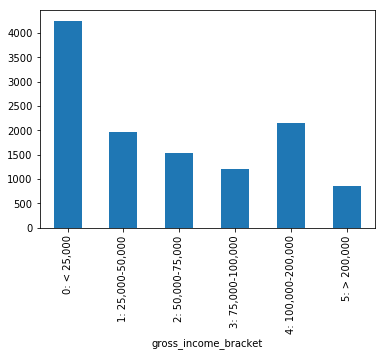

In [64]:
ca_tax_returns.loc['91307']['tax_returns_2007'].plot(kind='bar')